# Intro to Generative Adverserial Nets

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

/Users/Blackbak/Applications/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/Users/Blackbak/Downloads/mnist/")

Extracting /Users/Blackbak/Downloads/mnist/train-images-idx3-ubyte.gz
Extracting /Users/Blackbak/Downloads/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/Blackbak/Downloads/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/Blackbak/Downloads/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

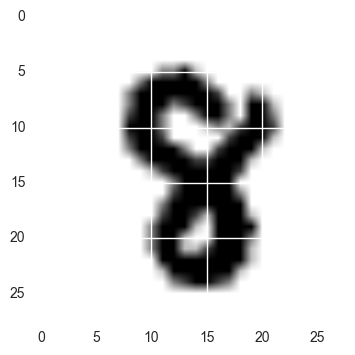

In [4]:
randomNum = np.random.randint(0,55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [5]:
x_train = MinMaxScaler(feature_range=(-1,1)).fit_transform(x_train)

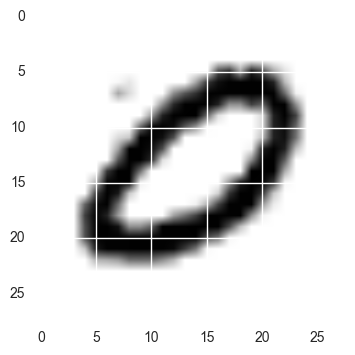

In [6]:
randomNum = np.random.randint(0,55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [17]:
input_discriminator_dimension = 28*28
input_generator_dimension = 2
discriminator_data = tf.placeholder(tf.float32, [None, input_discriminator_dimension])
generator_input = tf.placeholder(tf.float32, [None, input_generator_dimension])

In [18]:
def discriminator(data, input_dimension, layers, activation, reuse=False):
    with tf.variable_scope("discriminator") as scope:
        if reuse:
            scope.reuse_variables()
        Mi = input_dimension
        ###weights and bias initialization
        weights = {}
        bias = {}
        for layer, i in zip(layers, range(len(layers))):
            Mo = layer
            weights["weight_{}".format(i)] = tf.get_variable("d_w_{}".format(i),
                                                initializer=tf.random_normal(dtype=tf.float32, shape=[Mi, Mo])) 
            bias["bias_{}".format(i)] = tf.get_variable("d_b_{}".format(i), initializer=tf.zeros(Mo))
            Mi = Mo
        weights["out"] = tf.get_variable("d_w_out", 
                                         initializer=tf.random_normal(shape=[Mo, 1], dtype=tf.float32))
        bias["out"] = tf.get_variable("d_b_out", initializer=tf.zeros(1))
        ###forward pass
        layer_input = data
        for layer in range(len(layers)):
            layer_input = activation(tf.add(tf.matmul(layer_input, weights["weight_{}".format(layer)]), 
                                            bias["bias_{}".format(layer)]))
        logits = tf.add(tf.matmul(layer_input, weights["out"]), bias["out"])
        layer_out = tf.nn.sigmoid(logits)
    return layer_out, logits

In [25]:
def generator(data, input_dimension, output_dimension, layers, activation, reuse=False):
    with tf.variable_scope("generator") as scope:
        if reuse:
            scope.reuse_variables()
        Mi = input_dimension
        ###weights and bias initialization
        weights = {}
        bias = {}
        for layer, i in zip(layers, range(len(layers))):
            Mo = layer
            weights["weight_{}".format(i)] = tf.get_variable("g_w_{}".format(i), 
                                                initializer=tf.random_normal(dtype=tf.float32, shape=[Mi, Mo]))
            bias["bias_{}".format(i)] = tf.get_variable("g_b_{}".format(i), initializer=tf.zeros(Mo))
            Mi = Mo
        weights["out"] = tf.get_variable("g_w_out", 
                                         initializer=tf.random_normal(shape=[Mo, output_dimension], dtype=tf.float32))
        bias["out"] = tf.get_variable("g_b_out", initializer=tf.zeros(output_dimension))
        ###forward pass
        layer_input = data
        for layer in range(len(layers)):
            layer_input = activation(tf.add(tf.matmul(layer_input, weights["weight_{}".format(layer)]), 
                                            bias["bias_{}".format(layer)]))
        layer_out = tf.nn.tanh(tf.add(tf.matmul(layer_input, weights["out"]), bias["out"]))
    return layer_out

In [26]:
z_placeholder = tf.placeholder(tf.float32, [None, input_generator_dimension])
data_placeholder = tf.placeholder(tf.float32, [None, input_discriminator_dimension])

gen = generator(z_placeholder, input_dimension=input_generator_dimension, output_dimension=input_discriminator_dimension, layers=[350], activation=tf.nn.leaky_relu)
dis_data, dis_data_logits = discriminator(data_placeholder, input_dimension=input_discriminator_dimension, layers=[1500, 1500], activation=tf.nn.leaky_relu)
sampler = generator(z_placeholder, input_dimension=input_generator_dimension, output_dimension=input_discriminator_dimension, layers=[350], activation=tf.nn.leaky_relu, reuse=True)
dis_sample, dis_sample_logits = discriminator(sampler, input_dimension=input_discriminator_dimension, layers=[1500, 1500], activation=tf.nn.leaky_relu, reuse=True)

In [27]:
#cost_gen = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_sample_logits, labels=tf.ones_like(dis_sample)))
#cost_dis_data = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_data_logits, labels=tf.ones_like(dis_data)))
#cost_dis_sample = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_sample_logits, labels=tf.zeros_like(dis_sample)))
#cost_dis = cost_dis_data + cost_dis_sample
#cost_gen = -cost_dis
eps = 1e-2
cost_gen = tf.reduce_mean(-tf.log(dis_sample+eps))
cost_dis = tf.reduce_mean(-tf.log(dis_data+eps)-tf.log(1-dis_sample+eps))

In [28]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

adam = tf.train.AdamOptimizer(learning_rate=0.1)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    dis_opt = adam.minimize(cost_dis, var_list=d_vars)
    gen_opt = adam.minimize(cost_gen, var_list=g_vars)
#gen_opt = adam.minimize(-cost_gen, var_list=g_vars)

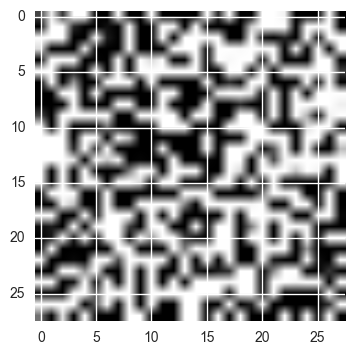

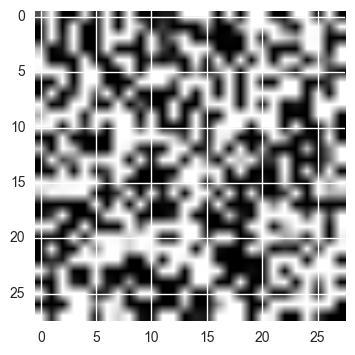

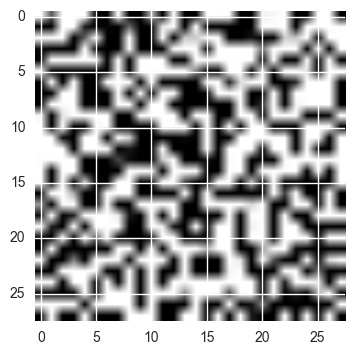

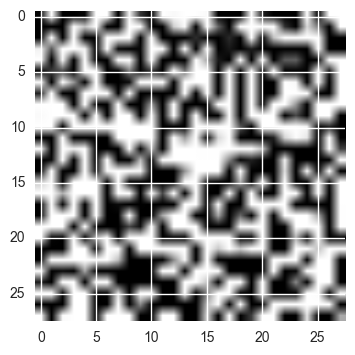

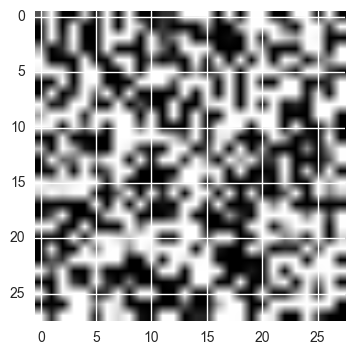

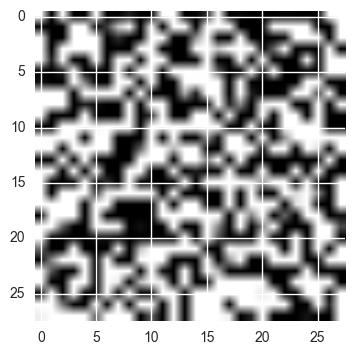

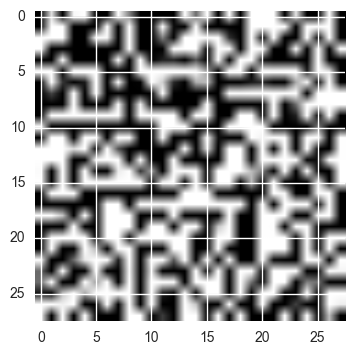

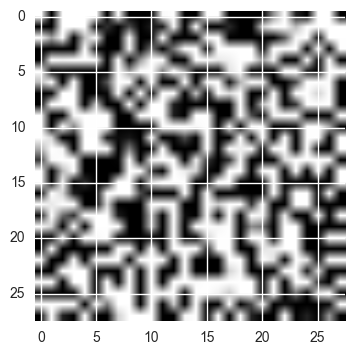

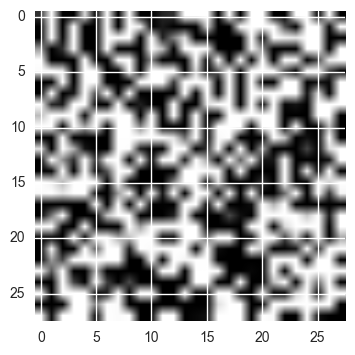

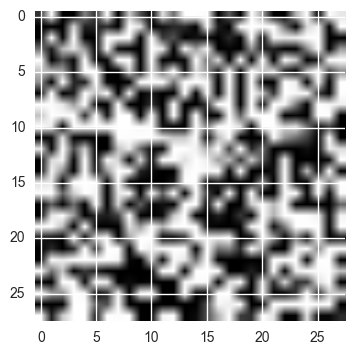

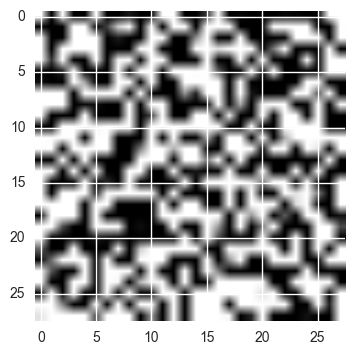

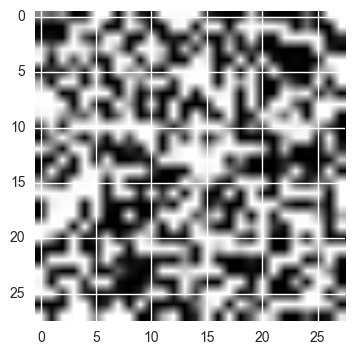

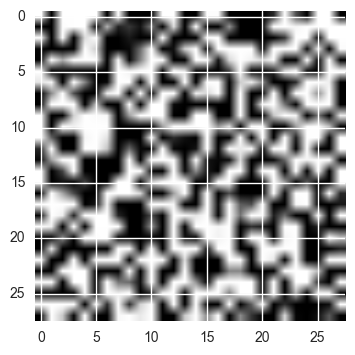

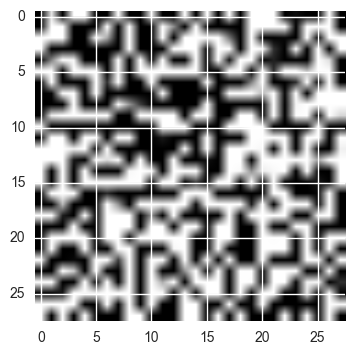

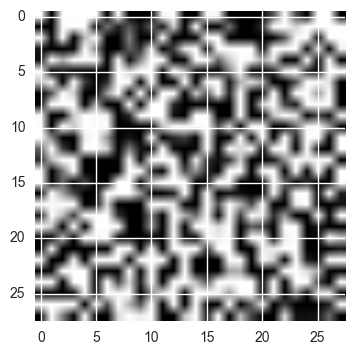

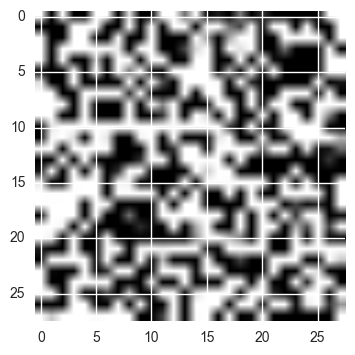

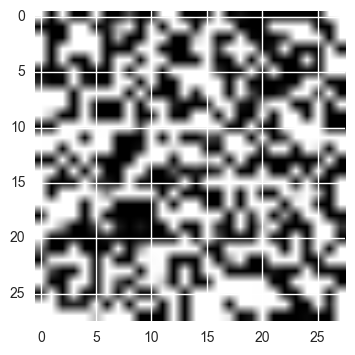

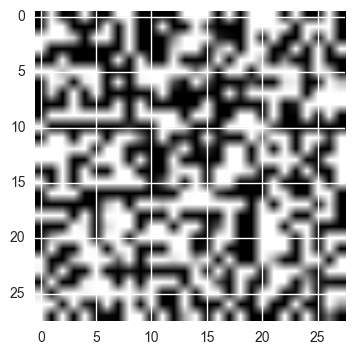

In [29]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
epochs = 3
batch_size = 100
g_c = []
d_c = []

for e in range(epochs):
    x_train = shuffle(x_train)
    for i in range(0, x_train.shape[0], batch_size):
        z_samples = np.random.uniform(-1,1, (batch_size, input_generator_dimension))
        x_batch = x_train[i:i+batch_size]
        _, d_c_b = sess.run([dis_opt, cost_dis], feed_dict={data_placeholder:x_batch, z_placeholder:z_samples})
        _, g_c_b = sess.run([gen_opt, cost_gen], feed_dict={z_placeholder:z_samples})
        if i%10000==0:
            d_c.append(d_c_b)
            g_c.append(g_c_b)
            image = sess.run(gen, feed_dict={z_placeholder:np.random.uniform(-1,1, (1, input_generator_dimension))}).reshape([28,28]) 
            plt.imshow(image, cmap=plt.get_cmap('gray_r'))
            plt.show()

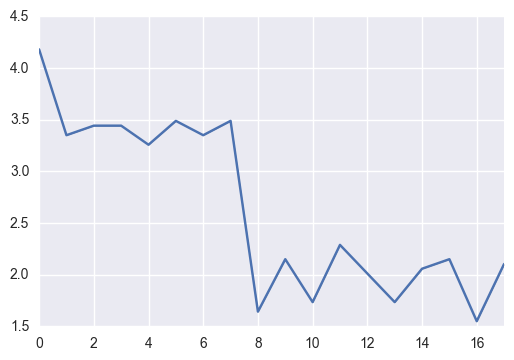

In [31]:
sns.tsplot(d_c)

In [31]:
z_test = np.random.uniform(-1,1, (1000, input_generator_dimension))
sampler = generator(z_placeholder,  input_dimension=input_generator_dimension, output_dimension=input_discriminator_dimension, layers=[100,500], activation=tf.nn.leaky_relu, reuse=True)
sampled_data = sess.run(sampler, feed_dict={z_placeholder:z_test})

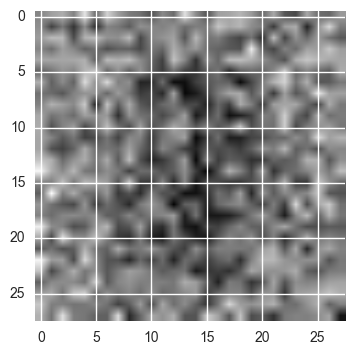

In [32]:
randomNum = np.random.randint(0,1000)
image = sampled_data[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [24]:
tf.reset_default_graph()

In [14]:
def cost(discriminator_data_output, discriminator_sample_output, generator_output):
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_sample_output,labels=tf.ones_like(discriminator_sample_output)))
    discriminator_data_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_data_output,labels=tf.ones_like(discriminator_data_output)))
    discriminator_sample_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=discriminator_sample_output,labels=tf.ones_like(discriminator_sample_output)))
    discriminator_loss = discriminator_data_loss + discriminator_sample_loss
    return generator_loss, discriminator_loss

def gen_train_op(generator_loss, discriminator_loss, learning_rate):
    ###for each step of the training we have to seperate the generator and discriminator variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'd_' in var.name]
    g_vars = [var for var in t_vars if 'g_' in var.name]
    generator_train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        generator_loss, var_list=g_vars)
    return generator_train


def dis_train_op(generator_loss, discriminator_loss, learning_rate):
    ###for each step of the training we have to seperate the generator and discriminator variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if 'd_' in var.name]
    g_vars = [var for var in t_vars if 'g_' in var.name]
    discriminator_train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        discriminator_loss, var_list=d_vars)
    return discriminator_train

In [64]:
def train(data, discriminator_train, generator_train, discriminator_loss, generator_loss, g_dim, epochs=3, batch_size=100):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sample_z = np.random.normal(loc=0, scale=1, size=(batch_size, g_dim))
        d_cost = []
        g_cost = []
        n_batches = int(data.shape[0]/batch_size)
        for e in range(epochs):
            data = shuffle(data)
            for i in range(0, data.shape[0], batch_size):
                batch_data = data[i:i+batch_size]
                _, g_loss = sess.run([generator_train, generator_loss], feed_dict={
                        generator_input:sample_z})
                _, d_loss = sess.run([discriminator_train, discriminator_loss], feed_dict={
                        discriminator_data:batch_data, generator_input:sample_z
                    })

In [12]:
discriminator_layers = [100, 100]
generator_layers = [100, 100]
learning_rate = 0.1
generator_output = generator(generator_input, input_dimension=input_generator_dimension,
                             output_dimension=input_discriminator_dimension, layers=generator_layers, 
                             activation=tf.nn.relu)
discriminator_data_output = discriminator(discriminator_data, input_discriminator_dimension, 
                                          discriminator_layers, activation=tf.nn.relu)
discriminator_sample_output = discriminator(generator_output, input_discriminator_dimension, 
                                          discriminator_layers, activation=tf.nn.relu, reuse=True)
generator_loss, discriminator_loss = cost(discriminator_data_output, discriminator_sample_output, generator_output)
generator_train, discriminator_train = train_op(generator_loss, discriminator_loss, learning_rate)

In [29]:
##we dont know if reuse works
##variable sharing for samples generated after training
##keep the same random inputs to the generator in training and generating samples and the get new ones

In [66]:
train(x, discriminator_train, generator_train, discriminator_loss, generator_loss, g_dim=3, epochs=3, batch_size=100)

ValueError: Cannot feed value of shape (100, 3) for Tensor 'Placeholder_1:0', which has shape '(?, 1)'

In [63]:
sampler = generator(generator_input, input_dimension=input_generator_dimension,
                             output_dimension=input_discriminator_dimension, layers=generator_layers, 
                             activation=tf.nn.relu, reuse=True)
with tf.Session() as sess:
    sess.run(sampler, feed_dict={generator_input:np.random.normal(0,1, size=(3,1))})

FailedPreconditionError: Attempting to use uninitialized value generator/g_b_out
	 [[Node: generator/g_b_out/read = Identity[T=DT_FLOAT, _class=["loc:@generator/g_b_out"], _device="/job:localhost/replica:0/task:0/cpu:0"](generator/g_b_out)]]

Caused by op 'generator/g_b_out/read', defined at:
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-b7123f3c95aa>", line 6, in <module>
    activation=tf.nn.relu)
  File "<ipython-input-6-1855449183ff>", line 16, in generator
    bias["out"] = tf.get_variable("g_b_out", initializer=tf.zeros(output_dimension))
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/Blackbak/Applications/anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value generator/g_b_out
	 [[Node: generator/g_b_out/read = Identity[T=DT_FLOAT, _class=["loc:@generator/g_b_out"], _device="/job:localhost/replica:0/task:0/cpu:0"](generator/g_b_out)]]


In [68]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    s = sess.run(discriminator_sample_output, feed_dict={generator_output:x})

In [72]:
(s<0.5).sum()

4906

In [55]:
generator_output

<tf.Tensor 'generator_2/Tanh:0' shape=(?, 2) dtype=float32>

In [57]:
discriminator_data_output

<tf.Tensor 'discriminator_1/Sigmoid:0' shape=(?, 1) dtype=float32>